## Problem Statement

A health tech company **‘BeHealthy’** has a web platform that allows doctors to list their services and manage patient interactions and provides services for patients such as booking interactions with doctors and ordering medicines online. Here, doctors can easily organise appointments, track past medical records and provide e-prescriptions.

Suppose we have been given such a data set in which a lot of text is written related to the medical domain. As we can see in the dataset, there are a lot of diseases that can be mentioned in the entire dataset and their related treatments are also mentioned implicitly in the text, Example, a disease mentioned is cancer and its treatment can be identified as chemotherapy using the sentence.

We need to build a custom NER to get the list of diseases and their treatment from the dataset.

### Solution

#### Data Provided
- Sentence file - contains all interations between patients and doctor
1. Train Sentence Dataset
2. Test Sentence Dataset
- Label file - contains all enitiy tags for particular words arranged as per sentence.
3. Train Label Dataset
4. Test Label Dataset

#### Core Libraries used
1. pands (for data processing)
2. re (for regex)
3. SpaCy (for NLP)
4. Sklearn_CRFsuite (to build CRF Model)

#### Model
In the realm of Medical Entity Recognition, we are building a CRF model with a custom NER tailored for medical terminologies, leveraging a dataset that includes labeled sentences, underscoring the significance of labels for entity recognition; in cases where data lacks labeling, manual annotation is necessary for model development and prediction.

- Upon reviewing the specifications, it becomes evident that our task involves the analysis of text sentences to identify specific entities, such as **"Disease"** and **"Treatment."** The fulfillment of these requirements can be achieved through the use of predictive methods.


## Expected Tasks

- Data Preprocessing (EDA)
- Observation of POS Tag and Repeated word frequencies for feature identification
- Create feature function and extract feature from each sentence
- Prepare input and Target variable for model
- Build CRF model
- Evaluate model using F1-score
- Predict disease and treatment

## Libraries import

In [109]:
#installing essentials first
!pip install pycrf
!pip install sklearn-crfsuite

In [110]:
# Setting up Google Colab for usage. Please disable if running locally.
import pathlib
import os
from google.colab import drive

# Library Import
import pandas as pd
import re
import spacy
import warnings
warnings.filterwarnings('ignore')

# Import model and metrics
from sklearn_crfsuite import CRF, scorers, metrics

In [111]:
#getting drive contents
drive.mount('/content/gdrive')
base_dir = pathlib.Path('/content/gdrive/MyDrive/NER_Custom_data')
os.chdir(str(base_dir))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Common Functions

### Preprocessing Functions

In [112]:
# Extract sentence from words
def content_extract(file_path='', sep='\t'):
    '''
    This function extracts sentences from a text file based on a specified separator.

    Args:
    - file_path (str): The path to the text file to be processed.
    - sep (str): The separator used to identify sentence boundaries.

    Returns:
    - sentence (list): A list of extracted sentences.
    '''
    try:
        with open(file_path, 'r', encoding='utf-8') as text:
            if text.mode == 'r':
                content = text.readlines()

        sentence = []
        final_sentence = ''

        for c in content:
            content_word = c.strip('\n')
            if content_word == '':
                # Once it matches the separator, it appends the previously extracted concatenated string as a sentence
                sentence.append(final_sentence.strip(' '))

                # Initialize for the next sentence
                final_sentence = ''
            else:
                # Until the loop identifies the separator, it concatenates the string
                final_sentence += content_word + ' '

        print('Total identified sentences: ', len(sentence), '\n')
        print('Sample displayed sentences:\n', sentence[:5])

        return sentence
    except FileNotFoundError:
        print('Check and provide a proper file path')

### Post-processing functions

In [113]:
# A class to retrieve the sentences details from the dataframe
class detailed_sentence(object):
    def __init__(self, data):
        # Initialize the class with the provided data
        self.data = data
        self.empty = False

        # Define an aggregation function to extract word, pos, and label information from the data
        agg_func = lambda s: [(w, p, l) for w, p, l in zip(s["word"].values.tolist(), s["pos"].values.tolist(), s["label"].values.tolist())]

        # Group the data by the "sentence" column and apply the aggregation function
        self.grouped = self.data.groupby("sentence").apply(agg_func)

        # Store the extracted sentences in a list
        self.sentences = [s for s in self.grouped]

### Feature Extraction - For sentence features

### `sentencefeatures` Function

This function generates a dictionary of features for a given word in a sentence. These features are commonly used in natural language processing and machine learning tasks, such as part-of-speech tagging or named entity recognition.

#### Features Extracted:

- `bias`: A constant feature with a value of 1.0.
- `word.lower()`: The lowercase version of the word.
- `word[0]`: The first character of the word.
- `word[-1]`: The last character of the word.
- `word[-2:]`: The last two characters of the word.
- `word.isupper()`: True if the word is in uppercase.
- `word.istitle()`: True if the word is in title case.
- `word.isdigit()`: True if the word consists of digits.
- `postag`: The part-of-speech tag of the word.
- `postag_isnounpronoun`: True if the part-of-speech tag is 'NOUN' or 'PROPN'.
- `postag[:2]`: The first two characters of the part-of-speech tag.

Additionally, it includes features for the previous and next words (if they exist in the sentence) with the prefix '-1' and '+1', respectively.

- Features for the previous word:
    - '-1:word.lower()'
    - '-1:word[0]'
    - '-1:word[-1]'
    - '-1:word.istitle()'
    - '-1:word.isupper()'
    - '-1:postag'
    - '-1:postag[:2]'
    - '-1:postag_isnounpronoun'

Args:
- `sent`: A list of words and their corresponding part-of-speech tags in the sentence.
- `i`: The index of the word for which features are generated within the sentence.

Returns:
- A dictionary containing the extracted features for the specified word.

In [114]:
# Feature set function
def sentencefeatures(sent, i):
    # Get the word and part-of-speech tag for the current word in the sentence
    word = sent[i][0]
    postag = sent[i][1]

    # Initialize a dictionary to store the features for the current word
    features = {
        'bias': 1.0,  # A bias feature (constant)
        'word.lower()': word.lower(),  # The lowercase version of the word
        'word[0]': word[0],  # The first character of the word
        'word[-1]': word[-1],  # The last character of the word
        'word[-2:]': word[-2:],  # The last two characters of the word
        'word.isupper()': word.isupper(),  # True if the word is in uppercase
        'word.istitle()': word.istitle(),  # True if the word is in title case
        'word.isdigit()': word.isdigit(),  # True if the word consists of digits
        'postag': postag,  # The part-of-speech tag of the word
        'postag_isnounpronoun': postag in ['NOUN', 'PROPN'],  # True if the part-of-speech tag is NOUN or PROPN
        'postag[:2]': postag[:2]  # The first two characters of the part-of-speech tag
    }

    # Features for the previous word (if it exists)
    if i > 0:
        word1 = sent[i - 1][0]
        postag1 = sent[i - 1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word[0]': word1[0],
            '-1:word[-1]': word1[-1],
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1:postag_isnounpronoun': postag1 in ['NOUN', 'PROPN']
        })
    else:
        features['BOS'] = True  # Beginning of sentence (BOS) indicator

    # Features for the next word (if it exists)
    if i < len(sent) - 1:
        word1 = sent[i + 1][0]
        postag1 = sent[i + 1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1:postag_isnounpronoun': postag1 in ['NOUN', 'PROPN']
        })
    else:
        features['EOS'] = True  # End of sentence (EOS) indicator

    # Return the dictionary of features for the current word
    return features

In [115]:
# Define a function to extract features for a sentence.
def sent2features(sent):
    return [sentencefeatures(sent, i) for i in range(len(sent))]

In [116]:
# Define a function to get the labels for a sentence.
def sent2labels(sent):
    return [label for token, postag, label in sent]

## EDA - Exploring the Data

### Pre-processing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**

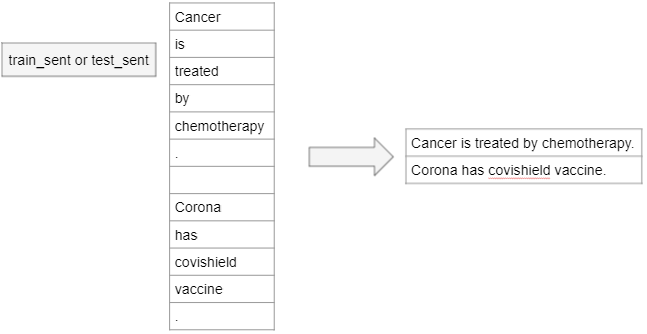

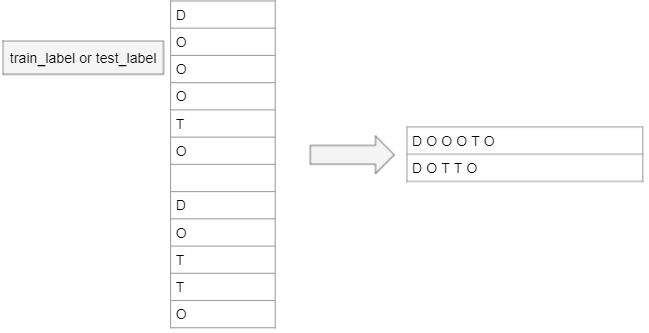

There are three labels that have been used in this dataset: **O, D and T**, which are corresponding to <font color = 'blue'>**Others**</font>, <font color = 'red'>**Disease**</font> and <font color = 'green'>**Treatment**</font>, respectively.

We need to do the following three tasks after processing and modifying the datasets:

- Construct proper sentences from individual words and print five sentences along with their labels.
- Print the correct count of the number of sentences in the processed train and test dataset.
- Correctly count the number of lines of labels in the processed train and test dataset.

## Uploading dataset

In [117]:
# Train sentence extraction from dataset
train_sent = content_extract(file_path='/content/gdrive/MyDrive/NER_Custom_data/train_sent',sep='\n')
# Train label extraction from dataset
train_label = content_extract(file_path='/content/gdrive/MyDrive/NER_Custom_data/train_label',sep='\n')
# Test sentence extraction from dataset
test_sent = content_extract(file_path='/content/gdrive/MyDrive/NER_Custom_data/test_sent',sep='\n')
# Test label extraction from dataset
test_label = content_extract(file_path='/content/gdrive/MyDrive/NER_Custom_data/test_label',sep='\n')

Total identified sentences:  2599 

Sample displayed sentences:
 ['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]
Total identified sentences:  2599 

Sample displayed sentences:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O

In [118]:
# Check the sample sentences (Top 5)
i=1
for sentence in test_sent[:5]:
    print(i,".",sentence,"\n")
    i+=1

1 . Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 ) 

2 . As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration 

3 . The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period 

4 . There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 ) 

5 . Fluctuations in ambient temperature are inversely correlated to changes in AFI 



### Finding POS tags

In [119]:
# Import spacy small library to find medical related entities
nlp= spacy.load("en_core_web_sm")

In [120]:
# Dataframe of POS tagging,Lemma word and Label for Train and test sentence
train_df = pd.DataFrame(columns=['sentence','word','lemma','pos','label'])
test_df = pd.DataFrame(columns=['sentence','word','lemma','pos','label'])

In [121]:
#train datframe


i=0 #Sentence count
j=0 #Iteration count

#iterate over pairs of train sentences and their corresponding labels
for sent,label in zip(train_sent,train_label):
    i+=1
    for s,l in zip(sent.split(),label.split()):
        doc = nlp(s)
        for tok in doc:
            train_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
            j+=1

In [122]:
#test datframe


i=0 #Sentence count track
j=0 #Iteration count track

#iterate over pairs of test sentences and their corresponding labels
for sent,label in zip(test_sent,test_label):
    i+=1
    for s,l in zip(sent.split(),label.split()):
        doc = nlp(s)
        for tok in doc:
            test_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
            j+=1

### Concept identification: Explore what are the various concepts present in the dataset

In [123]:
# Word and it's frequency for word which contains NOUN or PROPN as POS tagging
freq_df = pd.DataFrame()
freq_df = pd.concat((train_df,test_df),axis=0)

In [124]:
# Resetting index
freq_df.reset_index(inplace=True,drop=True)

In [125]:
# Top 25 most frequency values for Train and Test related dataset words
freq_df[(freq_df['pos'] == 'NOUN') | ((freq_df['pos'] == 'PROPN'))]['word'].value_counts()[:25]

patients        492
treatment       281
cancer          200
therapy         175
disease         143
cell            140
lung            116
group            94
gene             88
chemotherapy     88
effects          85
results          79
women            77
patient          75
TO_SEE           75
surgery          71
risk             71
cases            71
analysis         70
human            67
rate             67
response         66
survival         65
children         64
effect           64
Name: word, dtype: int64

In [126]:
# Top 25 most frequency values for Train and Test related lemma words
freq_df[(freq_df['pos'] == 'NOUN') | ((freq_df['pos'] == 'PROPN'))]['lemma'].value_counts()[:25]

patient         587
treatment       316
cancer          226
cell            203
therapy         182
disease         172
effect          163
case            132
group           128
lung            120
result          118
gene            112
year            105
rate            102
trial            91
chemotherapy     91
woman            89
analysis         86
protein          82
response         81
risk             78
child            78
human            77
TO_SEE           75
mutation         75
Name: lemma, dtype: int64

### Dataframe (Sentence, word, POS) visualisation

In [127]:
train_df.head(5)

,sentence,word,lemma,pos,label
0,1,All,all,PRON,O
1,1,live,live,VERB,O
2,1,births,birth,NOUN,O
3,1,>,>,PUNCT,O
4,1,or,or,CCONJ,O


In [128]:
test_df.head(5)

,sentence,word,lemma,pos,label
0,1,Furthermore,furthermore,ADV,O
1,1,",",",",PUNCT,O
2,1,when,when,SCONJ,O
3,1,all,all,PRON,O
4,1,deliveries,delivery,NOUN,O


### Sentense-wise detail dataframe preparation

In [129]:
# Fetch detail view of sentence for train set
train_sent_obj = detailed_sentence(train_df)
train_sent_detail = train_sent_obj.sentences

In [130]:
# Display one sentence detail view for train set
train_sent_detail[0]

[('All', 'PRON', 'O'),
 ('live', 'VERB', 'O'),
 ('births', 'NOUN', 'O'),
 ('>', 'PUNCT', 'O'),
 ('or', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('23', 'NUM', 'O'),
 ('weeks', 'NOUN', 'O'),
 ('at', 'ADP', 'O'),
 ('the', 'PRON', 'O'),
 ('University', 'NOUN', 'O'),
 ('of', 'ADP', 'O'),
 ('Vermont', 'PROPN', 'O'),
 ('in', 'ADP', 'O'),
 ('1995', 'NUM', 'O'),
 ('(', 'PUNCT', 'O'),
 ('n', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('2395', 'NUM', 'O'),
 (')', 'PUNCT', 'O'),
 ('were', 'AUX', 'O'),
 ('retrospectively', 'ADV', 'O'),
 ('analyzed', 'VERB', 'O'),
 ('for', 'ADP', 'O'),
 ('delivery', 'NOUN', 'O'),
 ('route', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('indication', 'NOUN', 'O'),
 ('for', 'ADP', 'O'),
 ('cesarean', 'VERB', 'O'),
 (',', 'PUNCT', 'O'),
 ('gestational', 'ADJ', 'O'),
 ('age', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('parity', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('and', 'CCONJ', 'O'),
 ('practice', 'VERB', 'O'),
 ('group', 'NOUN', 'O'),
 ('(', 'PUNCT', 'O'),
 ('to', 'PART', 'O'),
 ('reflect

In [131]:
# Fetch detail view of sentence for train set
test_sent_obj = detailed_sentence(test_df)
test_sent_detail = test_sent_obj.sentences

In [132]:
# Display one sentence detail view for train set
test_sent_detail[0]

[('Furthermore', 'ADV', 'O'),
 (',', 'PUNCT', 'O'),
 ('when', 'SCONJ', 'O'),
 ('all', 'PRON', 'O'),
 ('deliveries', 'NOUN', 'O'),
 ('were', 'AUX', 'O'),
 ('analyzed', 'VERB', 'O'),
 (',', 'PUNCT', 'O'),
 ('regardless', 'ADV', 'O'),
 ('of', 'ADP', 'O'),
 ('risk', 'NOUN', 'O'),
 ('status', 'NOUN', 'O'),
 ('but', 'CCONJ', 'O'),
 ('limited', 'VERB', 'O'),
 ('to', 'PART', 'O'),
 ('gestational', 'ADJ', 'O'),
 ('age', 'NOUN', 'O'),
 ('>', 'PUNCT', 'O'),
 ('or', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('36', 'NUM', 'O'),
 ('weeks', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('the', 'PRON', 'O'),
 ('rates', 'NOUN', 'O'),
 ('did', 'VERB', 'O'),
 ('not', 'PART', 'O'),
 ('change', 'VERB', 'O'),
 ('(', 'PUNCT', 'O'),
 ('12.6', 'NUM', 'O'),
 ('%', 'INTJ', 'O'),
 (',', 'PUNCT', 'O'),
 ('280', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('2214', 'NUM', 'O'),
 (';', 'PUNCT', 'O'),
 ('primary', 'NOUN', 'O'),
 ('9.2', 'NUM', 'O'),
 ('%', 'INTJ', 'O'),
 (',', 'PUNCT', 'O'),
 ('183', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('199

## Input and Target Variable

In [133]:
# Prepare X-train and X-test by extracting features from train and test dataset
X_train = [sent2features(s) for s in train_sent_detail]
X_test = [sent2features(s) for s in test_sent_detail]

In [134]:
# Prepare y-train and y-test by extracting labels from train and test dataset
y_train = [sent2labels(l) for l in train_sent_detail]
y_test = [sent2labels(l) for l in test_sent_detail]

## Building CRF model using sklearn

In [135]:
try:
    # Attempt to build and fit the CRF model.

    # Create a CRF model with specified hyperparameters
    crf = CRF(max_iterations=100, c1=1.0, c2=0.01, all_possible_transitions=False)

    # Fit the CRF model to the training data
    crf.fit(X_train, y_train)
except Exception as e:
    # Print an error message indicating that an error occurred and display the specific error message.
    print("An error occurred:", e)

## Evaluate model (F1-score)

In [136]:
# Calculate the f1 score using the test data
y_pred = crf.predict(X_test)
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print('Predicted F1-score for Medical Entity Dataset is: {0} % '.format(round(f1_score*100,2)))

Predicted F1-score for Medical Entity Dataset is: 91.47 % 


## Predict Disease and Treatment

In [137]:
# Taken out predicted label from the model
pred_label=[]
for i in y_pred:
    pred_label.extend(i)

In [138]:
# Loaded into test dataframe
test_df['label_predicted'] = pred_label

In [139]:
# Visualise top 5 data
test_df.head(5)

,sentence,word,lemma,pos,label,label_predicted
0,1,Furthermore,furthermore,ADV,O,O
1,1,",",",",PUNCT,O,O
2,1,when,when,SCONJ,O,O
3,1,all,all,PRON,O,O
4,1,deliveries,delivery,NOUN,O,O


###Preparing a dictionary by keeping Disease as a unique Key element and Treatment as the value element

In [140]:
# Create a new DataFrame containing non-'O' labeled entries
new_df = test_df[test_df['label_predicted'] != 'O']

# Set the 'sentence' column as the index of the new DataFrame
new_df.set_index('sentence', inplace=True)

# Initialize lists to store disease, treatment, and sentence information
disease = []  # To store unique disease labels
treatment = []  # To store treatment labels
sentence = []  # To store sentence information

# Initialize an empty dictionary to store disease-treatment pairs
med_dict = {}

# Iterate over unique sentence indices in the DataFrame
for i in new_df.index.unique():
    try:
        # Get the unique labels for the current sentence
        val = new_df.loc[i, 'label_predicted'].unique()

        # Check if there are both 'D' and 'T' labels in the sentence
        if len(val) == 2:
            # Extract the disease and treatment values for the current sentence
            disease_val = new_df[new_df['label_predicted'] == 'D'].loc[i, 'word']
            treatment_val = new_df[new_df['label_predicted'] == 'T'].loc[i, 'word']

            # Convert disease and treatment values to single strings if they are lists
            disease_single = disease_val if type(disease_val) == str else " ".join(disease_val)
            treatment_single = treatment_val if type(treatment_val) == str else " ".join(treatment_val)

            # Check if the disease is already in the 'disease' list
            if disease_single not in disease:
                # If not, add the disease as a unique key in the dictionary
                med_dict[disease_single] = treatment_single
            else:
                # If the disease is already in the 'disease' list, append the treatment to the existing dictionary value
                med_dict[disease_single] = med_dict.get(disease_single) + '/' + treatment_single
    except AttributeError:
        # Handle cases where there may be attribute errors (e.g., when fetching data)
        pass

In [141]:
next(iter(med_dict))

'gestational diabetes cases'

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [142]:
# Predict treatment with the help of a dictionary

# Initialize empty lists and variables
d = []  # To store token, part-of-speech, and "D" (for disease) tags
disease = ''  # To store the identified disease
test_sent = []  # To store the test sentence as features
treatment = ''  # To store the identified treatment

# Input sentence
input_sent = 'XYZ has hereditary retinoblastoma'

# Load the spaCy model for English
m = spacy.load('en_core_web_sm')

# Process the input sentence using spaCy
doc = m(input_sent)

# Extract token, part-of-speech, and "D" tag for each token in the input sentence
for i in doc:
    d.append((i.text, i.pos_, 'D'))

# Convert the list of token, part-of-speech, and "D" tags into features and add it to the test sentence list
test_sent.append(sent2features(d))

# Predict tags for the test sentence using the CRF model
for i, tag in enumerate(crf.predict(test_sent)[0]):
    if tag == 'D':
        tr = input_sent.split()[i]
        disease += tr  # Append the identified disease token
        if tr in med_dict:
            treatment += '' + med_dict.get(tr)  # Look up the treatment for the identified disease in the dictionary

# If no treatment is identified, set it to 'None'
if len(treatment) == 0:
    treatment = 'None'

# Print the identified disease and treatment
print('Disease: ', disease)
print('Treatment: ', treatment)

Disease:  retinoblastoma
Treatment:  radiotherapy
